In [15]:
from redbaron import redbaron
redbaron.ipython_behavior = False

import numpy as np
np.random.seed(0)  # reproduce tests
import scipy.signal
import pandas as pd
from pyha import Sfix, simulate, hardware_sims_equal, sims_close
import os

# this ignores some 'log' warnings that would fail the unit tests as they include system path
import warnings
warnings.filterwarnings('ignore')


import matplotlib
# set 'interactive' to False and run 'Restart & Run all' before you commit this notebook, else you will get failed tests in CI.
# also consider running in virtualenv, tests may fail if, for example, matplotlib versions differ
interactive = True
if interactive:
    matplotlib.use('nbagg')
    from pylab import rcParams
    rcParams['figure.figsize'] = 9, 4
    %load_ext autoreload
    %autoreload 2
    
import matplotlib.pyplot as plt
def show_plot():
    plt.tight_layout()
    plt.grid()
    if plt.gca().get_legend_handles_labels() != ([], []):
        plt.legend()
    plt.show()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Design filter

<IPython.core.display.Javascript object>


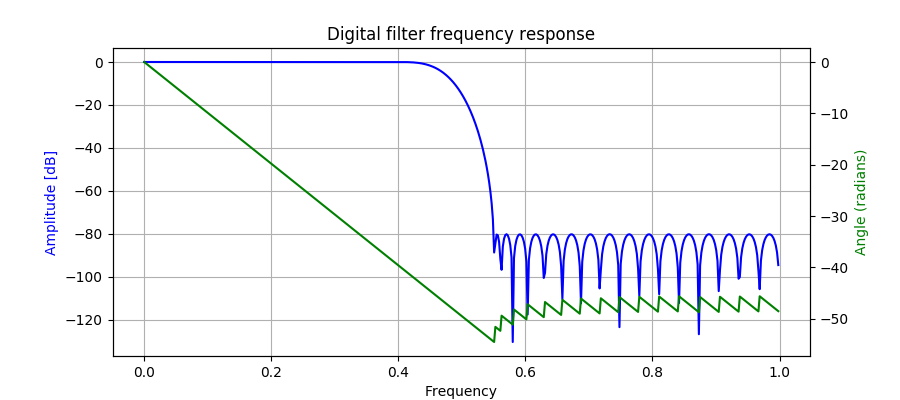

In [16]:
taps = scipy.signal.remez(64, [0, 0.2, 0.275, 0.5], [1, 0])
w, h = scipy.signal.freqz(taps)

fig, ax1 = plt.subplots(1, 1)
plt.title('Digital filter frequency response')
ax1.plot(w / np.pi, 20 * np.log10(abs(h)), 'b')
ax1.set_ylabel('Amplitude [dB]', color='b')
ax1.set_xlabel('Frequency')
plt.grid()
ax2 = ax1.twinx()
angles = np.unwrap(np.angle(h))
ax2.plot(w / np.pi, angles, 'g')
ax2.set_ylabel('Angle (radians)', color='g')
ax2.axis('tight')
plt.show()

# Diagram

![alt text](diagram.png "Title")

In [17]:
# scipy.signal.lfilter(taps, [1.0], filter_input)

# Pyha model

In [18]:
from pyha import Hardware, Complex
from pyhacores.filter import FIR

class BasebandFilter(Hardware):
    def __init__(self, taps):
        self.TAPS = taps
        self.fir = [FIR(taps), FIR(taps)]
        
        self.DELAY = 2
    def main(self, x):
        real = self.fir[0].main(x.real)
        imag = self.fir[1].main(x.imag)
        return Complex(real, imag)

    def model_main(self, x):
        return scipy.signal.lfilter(self.TAPS, [1.0], x)
    
dut = BasebandFilter(taps)
# simulations = ['MODEL', 'PYHA', 'RTL', 'GATE']
simulations = ['MODEL', 'PYHA', 'RTL']
# simulate(...)

# Experiment 1: frequency response

In [23]:
# get impulse response of the filter
inp = [0.0 + 0.0j] * 512
inp[0] = 1.0 + 1.0j

In [24]:
# with Sfix._float_mode:
sims = simulate(dut, inp, simulations=simulations)

INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Converting model to hardware types ...
INFO:core:Converted FIR.TAPS:
                    fixed     float
0    7.62939e-06 [0:-17]  0.000006
1    0.000152588 [0:-17]  0.000151
2    7.62939e-06 [0:-17]  0.000006
3   -0.000328064 [0:-17] -0.000329
4   -9.15527e-05 [0:-17] -0.000091
5    0.000648499 [0:-17]  0.000650
6    0.000312805 [0:-17]  0.000315
7    -0.00111389 [0:-17] -0.001115
8   -0.000778198 [0:-17] -0.000779
9     0.00171661 [0:-17]  0.001719
10    0.00161743 [0:-17]  0.001615
11   -0.00241089 [0:-17] -0.002414
12   -0.00298309 [0:-17] -0.002980
13    0.00309753 [0:-17]  0.003098
14    0.00505066 [0:-17]  0.005048
15   -0.00360107 [0:-17] -0.003599
..                   ...       ...
48   -0.00360107 [0:-17] -0.003599
49    0.00505066 [0:-17]  0.005048
50    0.00309753 [0:-17]  0.003098
51   -0.00298309 [0:-17] -0.002980
52   -0.00241089 [0:-17] -0.002414
53    0.00161743 [0:-17]  0.001615
54    0.00171661 [0:-17]  0.0

In [21]:
pd.DataFrame(sims)

,MODEL,PYHA,RTL
0,(4.6603104543388265e-07+2.2922530010606706e-06j),0j,0j
1,(1.3094571268815598e-05+5.602611617961615e-05j),(7.62939453125e-06+5.340576171875e-05j),(7.62939453125e-06+5.340576171875e-05j)
2,(5.009918488253122e-05+4.420295073141948e-05j),(4.57763671875e-05+3.814697265625e-05j),(4.57763671875e-05+3.814697265625e-05j)
3,(1.526991409275185e-06-8.729924011050562e-05j),-9.1552734375e-05j,-9.1552734375e-05j
4,(-0.0001026520360869239-7.613539561439346e-05j),(-0.0001068115234375-7.62939453125e-05j),(-0.0001068115234375-7.62939453125e-05j)
5,(-4.811141899822728e-05+8.252880547341679e-05j),(-5.340576171875e-05+7.62939453125e-05j),(-5.340576171875e-05+7.62939453125e-05j)
6,(0.0002282416313600458+0.00013166047248411455j),(0.00022125244140625+0.00012969970703125j),(0.00022125244140625+0.00012969970703125j)
7,(0.00014264098073652642-3.806752796487898e-05j),(0.0001373291015625-4.57763671875e-05j),(0.0001373291015625-4.57763671875e-05j)
8,(-0.00029390268664363325-0.00011307855997805032j),(-0.00029754638671875-0.00011444091796875j),(-0.00029754638671875-0.00011444091796875j)
9,(-0.00023244832644047335-3.895922782125637e-05j),(-0.00023651123046875-4.57763671875e-05j),(-0.00023651123046875-4.57763671875e-05j)


<IPython.core.display.Javascript object>


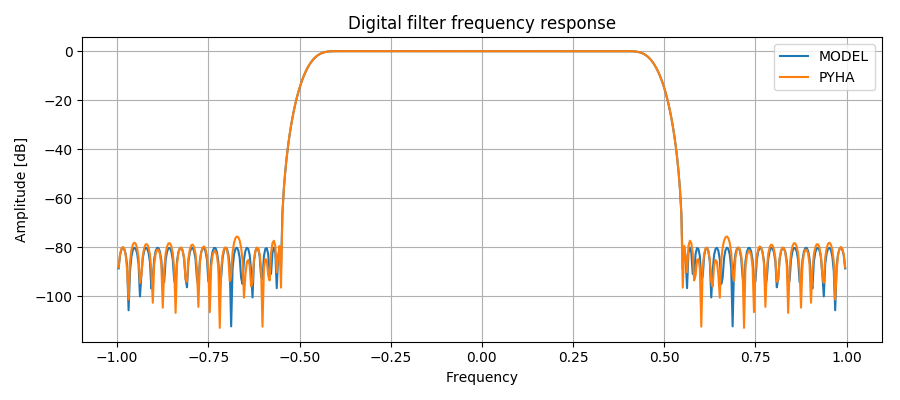

In [25]:
gain_fix = 512-128-22
plt.title('Digital filter frequency response')
plt.magnitude_spectrum(np.array(sims['MODEL']) * gain_fix, window=matplotlib.mlab.window_none, scale='dB', label='MODEL')
plt.magnitude_spectrum(np.array(sims['PYHA']) * gain_fix, window=matplotlib.mlab.window_none, scale='dB', label='PYHA')

plt.ylabel('Amplitude [dB]')
plt.xlabel('Frequency')
show_plot()

# Experiment 2: two peaks

<IPython.core.display.Javascript object>


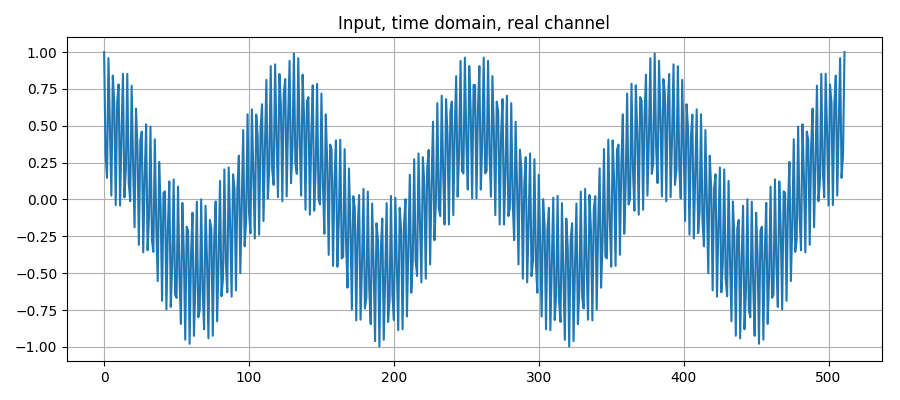

<IPython.core.display.Javascript object>


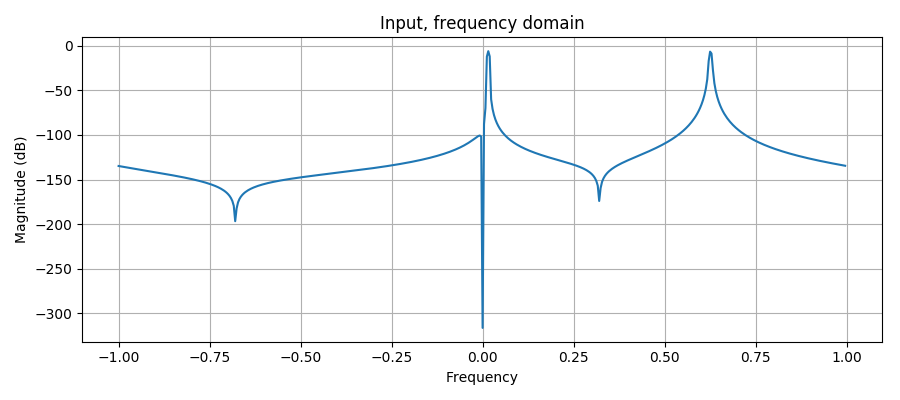

In [26]:
fs = 256
t = np.linspace(0, 2, 2*fs)
s0 = np.exp(2 * np.pi * 2 * t * 1j) * 0.5
s1 = np.exp(2 * np.pi * 80 * t * 1j) * 0.5
inp = s0 + s1

plt.title('Input, time domain, real channel')
plt.plot(inp.real)
show_plot()

plt.title('Input, frequency domain')
plt.magnitude_spectrum(inp, scale='dB')
show_plot()

In [27]:
sims = simulate(dut, inp, simulations=simulations)

INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Converting model to hardware types ...
INFO:core:Converted FIR.TAPS:
                    fixed     float
0    7.62939e-06 [0:-17]  0.000006
1    0.000152588 [0:-17]  0.000151
2    7.62939e-06 [0:-17]  0.000006
3   -0.000328064 [0:-17] -0.000329
4   -9.15527e-05 [0:-17] -0.000091
5    0.000648499 [0:-17]  0.000650
6    0.000312805 [0:-17]  0.000315
7    -0.00111389 [0:-17] -0.001115
8   -0.000778198 [0:-17] -0.000779
9     0.00171661 [0:-17]  0.001719
10    0.00161743 [0:-17]  0.001615
11   -0.00241089 [0:-17] -0.002414
12   -0.00298309 [0:-17] -0.002980
13    0.00309753 [0:-17]  0.003098
14    0.00505066 [0:-17]  0.005048
15   -0.00360107 [0:-17] -0.003599
..                   ...       ...
48   -0.00360107 [0:-17] -0.003599
49    0.00505066 [0:-17]  0.005048
50    0.00309753 [0:-17]  0.003098
51   -0.00298309 [0:-17] -0.002980
52   -0.00241089 [0:-17] -0.002414
53    0.00161743 [0:-17]  0.001615
54    0.00171661 [0:-17]  0.0

<IPython.core.display.Javascript object>


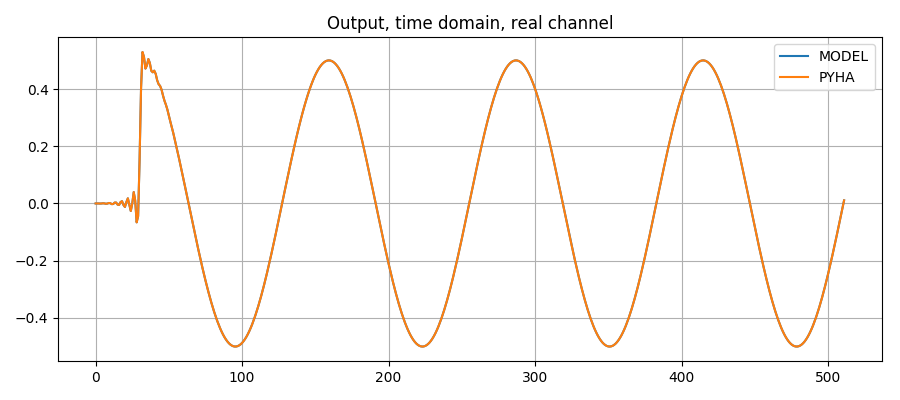

<IPython.core.display.Javascript object>


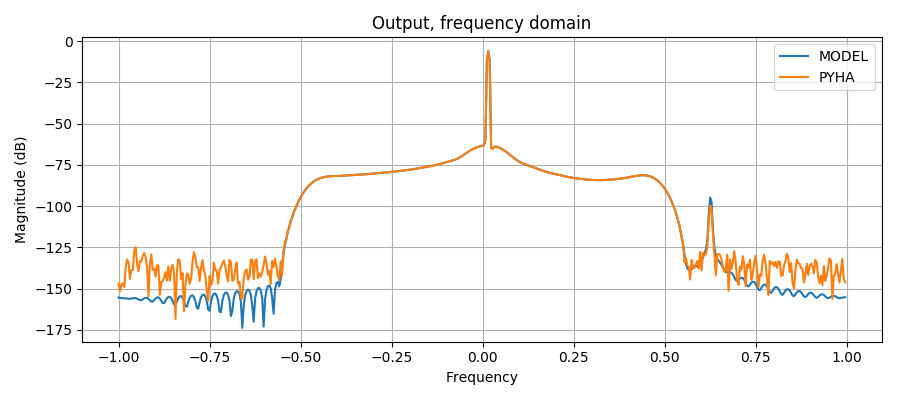

In [28]:
plt.title('Output, time domain, real channel')
plt.plot(np.array(sims['MODEL']).real, label='MODEL')
plt.plot(np.array(sims['PYHA']).real, label='PYHA')
show_plot()

plt.title('Output, frequency domain')
plt.magnitude_spectrum(sims['MODEL'], scale='dB', label='MODEL')
plt.magnitude_spectrum(sims['PYHA'], scale='dB', label='PYHA')
show_plot()

# Noise response

In [29]:
inp = np.random.uniform(-1, 1, 512) + np.random.uniform(-1, 1, 512)*1j
inp *= 0.75

sims = simulate(dut, inp, simulations=simulations)

INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Converting model to hardware types ...
INFO:core:Converted FIR.TAPS:
                    fixed     float
0    7.62939e-06 [0:-17]  0.000006
1    0.000152588 [0:-17]  0.000151
2    7.62939e-06 [0:-17]  0.000006
3   -0.000328064 [0:-17] -0.000329
4   -9.15527e-05 [0:-17] -0.000091
5    0.000648499 [0:-17]  0.000650
6    0.000312805 [0:-17]  0.000315
7    -0.00111389 [0:-17] -0.001115
8   -0.000778198 [0:-17] -0.000779
9     0.00171661 [0:-17]  0.001719
10    0.00161743 [0:-17]  0.001615
11   -0.00241089 [0:-17] -0.002414
12   -0.00298309 [0:-17] -0.002980
13    0.00309753 [0:-17]  0.003098
14    0.00505066 [0:-17]  0.005048
15   -0.00360107 [0:-17] -0.003599
..                   ...       ...
48   -0.00360107 [0:-17] -0.003599
49    0.00505066 [0:-17]  0.005048
50    0.00309753 [0:-17]  0.003098
51   -0.00298309 [0:-17] -0.002980
52   -0.00241089 [0:-17] -0.002414
53    0.00161743 [0:-17]  0.001615
54    0.00171661 [0:-17]  0.0

<IPython.core.display.Javascript object>


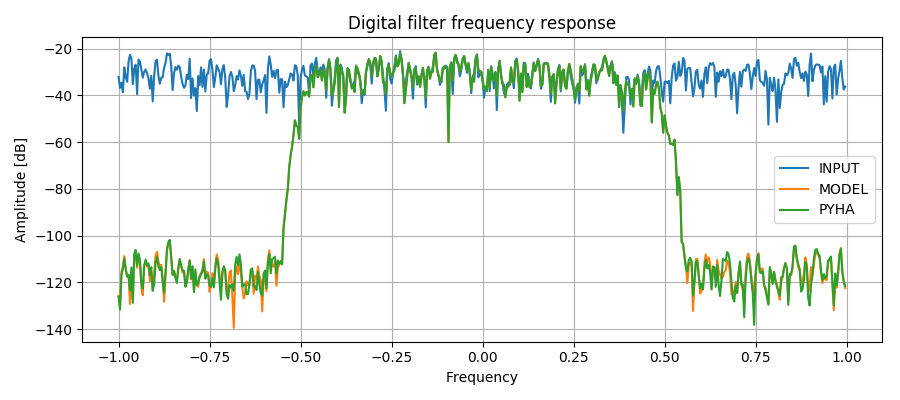

In [30]:
plt.title('Digital filter frequency response')
plt.magnitude_spectrum(inp, scale='dB', label='INPUT')
plt.magnitude_spectrum(sims['MODEL'], scale='dB', label='MODEL')
plt.magnitude_spectrum(sims['PYHA'], scale='dB', label='PYHA')
plt.ylabel('Amplitude [dB]')
plt.xlabel('Frequency')
show_plot()